<a href="https://colab.research.google.com/github/sergey7-bit/-/blob/main/%D0%A1%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B4%D0%B8%D0%B0%D0%BB%D0%BE%D0%B3%D0%B0_%D1%81_chatGPT_%D0%A1%D0%BE%D0%B5%D0%B4%D0%B8%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BD%D0%B5%D1%81%D0%BA%D0%BE%D0%BB%D1%8C%D0%BA%D0%B8%D1%85_chatGPT_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9_%7C_%D0%A3%D0%98%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Возьмите за основу консультанта компании POSTOPLAN, автоматизированной платформы маркетинга в соцсетях и мессенджерах, созданной нами на уроке "Создание диалога с chatGPT. Соединение нескольких chatGPT моделей", добавьте консультанту генерацию аудио файла из ответа модели GPT.

Чтобы изменить содержимое ячейки, дважды нажмите на нее (или выберите "Ввод")
Для Синтеза речи можно использовать любую нейронную сеть с подбором параметов.

Обратите внимание, что каждый сервис ставит ограничение на бесплатную генерацию аудиоконтента, поэтому рекомендуем в промте дать указание модели отвечать в одно предложение.

In [7]:
!pip install langchain==0.2.14 langchain-core==0.2.33 langchain-community==0.2.12 langchain-text-splitters==0.2.2 langchain-openai==0.1.22 openai==1.63.0 tiktoken==0.7.0 faiss-cpu numpy==1.26.4

In [9]:
# импортируем необходимые библиотеки
from openai import OpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter, CharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain.docstore.document import Document
import os
import re
import requests
import openai
import tiktoken
import matplotlib.pyplot as plt
import textwrap
from textwrap import fill

import logging
logging.getLogger("langchain.text_splitter").setLevel(logging.ERROR)

In [11]:
# использование секретного ключа в колабе
from google.colab import userdata
# Получение API ключа из пользовательских данных Colab и установка его как переменной среды
key = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = key


In [12]:
# Создание клиента OpenAI с использованием API ключа из переменных среды
client = OpenAI()

In [13]:
# функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [14]:
# База знаний, которая будет подаваться в langChain
database= load_document_text('https://docs.google.com/document/d/1rihIt6rnBHfrv42C1ALtpoHoS2jIVseCg49aWqsOyk4')

In [15]:
database[:1000]

'\ufeff#  Пусть соцсети работают на вас\r\n\r\n\r\n##  Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент\r\n\r\n\r\nPOSTOPLAN отмечен наградами, ему доверяют 50 000+ специалистов и компаний из 147 стран\r\n76% уменьшили время работы в соцсетях более, чем на 4 часа в неделю\r\n15% увеличили количество клиентов уже в первые месяцы работы с сервисом\r\n55% отметили увеличение охвата постов и рост аудитории\r\n\r\n\r\n##  Создаём выдающиеся возможности для маркетинга в соцсетях\r\n\r\n\r\n1. Гибкие подписки: платите только за подключенные аккаунты, без лишних расходов и переплат\r\n2. Количество пользователей \r\n3. неограниченно: добавляйте коллег, клиентов или сотрудников для командной работы над проектами\r\n4. Количество проектов \r\n5. неограниченно: создавайте сколько угодно рабочих проектов и давайте к ним доступ членам команды\r\n6. Постинг 24/7: ведите сразу все нужные вам аккаунты на единой платформе\r\n7. Фоторедактор и библиотека с 2 млн. изображений: со

Дублируем текст заголовков без символов "#", чтобы тексты заголовков не пропали из чанков при использовании MarkdownHeaderTextSplitter  

In [16]:
def duplicate_headers_without_hashes(text):
    """
    Дублирует заголовки в тексте, убирая из дубликатов хэши.

    Например:
    '# Заголовок' превращается в:
    '# Заголовок
    Заголовок'
    """

    # Вспомогательная функция, которая будет вызываться для каждого найденного совпадения в тексте
    def replacer(match):
        # match.group() вернет найденный заголовок с хэшами.
        # затем мы добавляем к нему перенос строки и ту же строку, но без хэшей
        return match.group() + "\n" + match.group().replace("#", "").strip()

    # re.sub ищет в тексте все заголовки, начинающиеся с 1 до 3 хэшей, и заменяет их
    # с помощью функции replacer
    result = re.sub(r'#{1,3} .+', replacer, text)

    return result

In [17]:
database=duplicate_headers_without_hashes(database)

In [19]:
# при необходимости предобработанную БЗ можно сохранить:
with open('Postoplan.txt', 'w') as f:
    f.write(database)

from google.colab import files
files.download('Postoplan.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
database[:10000]

'\ufeff#  Пусть соцсети работают на вас\r\nПусть соцсети работают на вас\n\r\n\r\n##  Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент\r\nСоцсети на автопилоте — создавайте, планируйте и продвигайте свой контент\n\r\n\r\nPOSTOPLAN отмечен наградами, ему доверяют 50 000+ специалистов и компаний из 147 стран\r\n76% уменьшили время работы в соцсетях более, чем на 4 часа в неделю\r\n15% увеличили количество клиентов уже в первые месяцы работы с сервисом\r\n55% отметили увеличение охвата постов и рост аудитории\r\n\r\n\r\n##  Создаём выдающиеся возможности для маркетинга в соцсетях\r\nСоздаём выдающиеся возможности для маркетинга в соцсетях\n\r\n\r\n1. Гибкие подписки: платите только за подключенные аккаунты, без лишних расходов и переплат\r\n2. Количество пользователей \r\n3. неограниченно: добавляйте коллег, клиентов или сотрудников для командной работы над проектами\r\n4. Количество проектов \r\n5. неограниченно: создавайте сколько угодно рабочих проектов и давай

In [21]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

def split_text(text):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
    ]

    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    # Подсчет токенов для каждого фрагмента и построение графика
    fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in fragments]
    plt.hist(fragment_token_counts, bins=50, alpha=0.5, label='Fragments')
    plt.title('Распределение длин чанков в токенах')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    return fragments

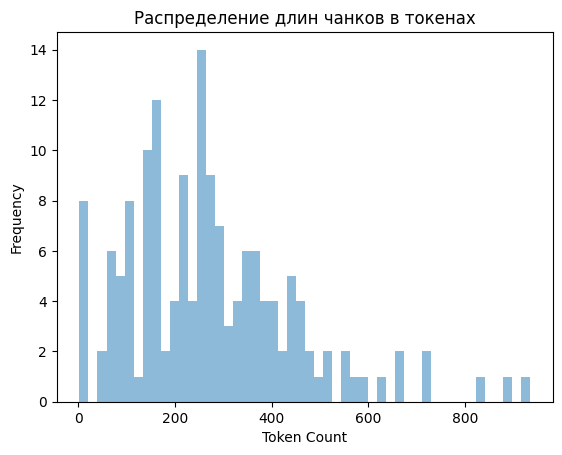

In [22]:
source_chunks=split_text(database)

In [23]:
source_chunks[1]

Document(metadata={'Header 1': 'Пусть соцсети работают на вас', 'Header 2': 'Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент'}, page_content='Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент  \nPOSTOPLAN отмечен наградами, ему доверяют 50 000+ специалистов и компаний из 147 стран\n76% уменьшили время работы в соцсетях более, чем на 4 часа в неделю\n15% увеличили количество клиентов уже в первые месяцы работы с сервисом\n55% отметили увеличение охвата постов и рост аудитории')

In [24]:
# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()
# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(source_chunks, embeddings)


In [25]:
# Инструкция для GPT, которая будет подаваться в system
system= load_document_text('https://docs.google.com/document/d/1K1bQt7V-dVMIfwTK27-YicWrhgVTz8xmvtCrQLjC_d4')

In [26]:
system

'\ufeffТы-нейро-консультант в компании POSTOPLAN, автоматизированной платформы маркетинга в соцсетях и мессенджерах. Далее тебе будет представлена следующая информация: саммаризированный предыдущий диалог с пользователем, актуальный вопрос пользователя, документы с информацией для ответа клиенту. Твоя задача - полно и точно ответить на вопрос пользователя по поводу компании POSTOPLAN, их продукте, ценах, тарифах.  Особенно аккуратно отвечай по цифрам - тарифам и  тому, что входит в каждый тариф. В своем ответе основывайся только на представленных тебе документах, не придумывай ничего “от себя”, однако пользователю об этих документах и их номерах не сообщай. \r\nЕсли пользователь представился (назвал свое имя), используй его имя при ответе. \r\nЕсли в кратком обзоре предыдущего диалога фигурирует имя пользователя, обязательно используй его в ответе, обращайся к пользователю по имени.\r\nТебе запрещено здороваться с пользователем'

In [27]:
def answer_index(system, search_query, topic, search_index, verbose=0):
    # Поиск релевантных отрезков из базы знаний по вопросу пользователя
    docs = search_index.similarity_search(search_query, k=3)
    if verbose:
        print('\n ===========================================: ')

    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)]))
    if verbose:
        print('message_content :\n ======================================== \n', message_content)

    client = OpenAI()
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Ответь на вопрос пользователя. Документы с информацией для ответа клиенту: {message_content}\n\n{topic}"}
    ]

    if verbose:
        print('\n ===========================================: ')

    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0.1
    )
    answer = completion.choices[0].message.content
    return answer


Делаем функцию, которая будет саммаризировать диалог по мере его накапливания, и данную саммаризацию мы будем подавать модели, которая отвечает на вопрос клиента, чтобы модель учитывала контекст диалога.

In [28]:
def summarize_questions(dialog):
    """
    Функция возвращает саммаризированный текст диалога.
    """
    messages = [
        {"role": "system", "content": "Ты - нейро-саммаризатор. Твоя задача - саммаризировать диалог, который тебе пришел. Если пользователь назвал свое имя, обязательно отрази его в саммаризированном диалоге"},
        {"role": "user", "content": "Саммаризируй следующий диалог консультанта и пользователя, тебе запрещено удалять из саммаризации имя пользователя: " + " ".join(dialog)}
    ]

    completion = client.chat.completions.create(
        model="gpt-4o-mini",     # используем gpt4 для более точной саммаризации
        messages=messages,
        temperature=0,          # Используем более низкую температуру для более определенной суммаризации
    )

    return completion.choices[0].message.content

Далее следует основная функция, объединяющая все предыдущие. В нее мы подаем инструкцию, базу знаний, текущий вопрос клиента из чата, а также историю предыдущего диалога - при наличии.

In [29]:
def answer_user_question_dialog(system, db, user_question, question_history):
    """
    Функция возвращает ответ на вопрос пользователя.
    """
    summarized_history = ""
    # Если в истории более одного вопроса, применяем суммаризацию
    if len(question_history) > 0:
        summarized_history = "Вот саммаризированный предыдущий диалог с пользователем: " + summarize_questions([q + ' ' + (a if a else '') for q, a in question_history])

    topic = summarized_history + " Актуальный вопрос пользователя: " + user_question

    # Получаем ответ, используя только user_question для поиска в базе данных
    answer_text = answer_index(system, user_question, topic, db)

    question_history.append((user_question, answer_text if answer_text else ''))
    # Выводим саммаризированный текст, который видит модель
    if summarized_history:
        print('****************************')
        print(summarized_history)
        print('****************************')

    return answer_text


Следующая функция запускает диалог с клиентом и останавливает его при вводе слова "stop".

In [30]:
def run_dialog(system_doc_url, knowledge_base_url):
    """
    Функция запускает диалог между пользователем и нейро-консультантом.
    """
    #список кортежей, где каждый кортеж содержит пару вопрос-ответ, для отслеживания истории вопросов и ответов во время сессии диалога.
    question_history = []
    while True:
        user_question = input('Пользователь: ')
        if user_question.lower() == 'stop':
            break
        answer = answer_user_question_dialog(system_doc_url, knowledge_base_url, user_question, question_history)
        print('Консультант:', textwrap.fill(answer))

    return

In [31]:
run_dialog(system, db)

Пользователь: привет
Консультант: Вопрос не содержит конкретной информации, на которую можно ответить.
Если у тебя есть вопросы о тарифах, функциях или чем-то еще,
пожалуйста, уточни, и я с радостью помогу!
Пользователь: что такое постоплан
****************************
Вот саммаризированный предыдущий диалог с пользователем: Пользователь приветствует консультанта и задает вопрос, который не содержит конкретной информации. Консультант предлагает уточнить вопросы о тарифах, функциях или других темах, чтобы помочь.
****************************
Консультант: POSTOPLAN — это автоматизированная платформа для маркетинга в
социальных сетях и мессенджерах. Она позволяет пользователям
планировать и управлять публикациями в различных социальных сетях из
одного места, что значительно упрощает процесс ведения аккаунтов.   С
помощью POSTOPLAN вы можете настроить автопостинг, что позволяет вам
не беспокоиться о том, что вы забудете опубликовать важную информацию.
Платформа также предлагает банк идей д

# Нейро-продажник из 3 моделей gpt

In [33]:
database = load_document_text('https://docs.google.com/document/d/199yEDg1EIlTImWjFR4FGRsqw70mjlP85jG8XduD6B24') # база знаний

In [34]:
system_1 = load_document_text('https://docs.google.com/document/d/1xFYprEaF47_uiNHo4JQJevpVV6v5mG2v6mZXy93MZQA') # инструкция для первой модели

In [35]:
system_2 = load_document_text('https://docs.google.com/document/d/12nLPgHv_HJMPnuGWlWVhOne9dH9-04cLSyusO0AVQ9o') # инструкция для второй модели

In [36]:
system_3 = load_document_text('https://docs.google.com/document/d/1oY6-HEfL5NDvnvWaxrW_HqAs0tMX0ogpB8I1OXbbgx0') # инструкция для третьей модели

In [38]:
# делим текст на чанки и создаем индексную базу
source_chunks = []
splitter = CharacterTextSplitter(separator="\n", chunk_size=1024, chunk_overlap=0)

for chunk in splitter.split_text(database):
    source_chunks.append(Document(page_content=chunk, metadata={"meta":"data"}))

# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()

# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(source_chunks, embeddings)

In [39]:
MODEL_GPT_4O_mini = "gpt-4o-mini"
MODEL_GPT_4O = "gpt-4o"

def create_completion(model, system, content, temperature):
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": content}
    ]
    client = OpenAI()
    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0

    )
    return completion.choices[0].message.content

def create_completion_with_assistant(system, user_assist, assistant, user, temp=0, model='gpt-4o-mini'):
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": user_assist},
        {'role':'assistant', 'content': assistant},
        {"role": "user", "content": f"{user}"}

    ]
    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp
    )
    answer = completion.choices[0].message.content
    return answer

def first_model(system_1, db, topic, temperature=0):
    docs = db.similarity_search(topic, k=4)
    message_content = ' '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)])
    question_content = f"""Ты - менеджер по продажам в университете искусственного интеллекта. Ответь на вопрос пользователя на основании
    представленных документов и задай вопросы для выявления потребностей клиента.
    Документ с информацией для ответа клиенту: {message_content}\n\nВопрос клиента: \n{topic}"""
    return fill(create_completion(MODEL_GPT_4O_mini, system_1, question_content, 0))

def second_model(topic):
    user_assist = """Определи, были ли в переданных сообщениях клиента названы потребности и возражения. Потребности у клиента могут быть следующие: в трудоустройстве, в росте дохода,
                в возможности работать удаленно, развиваться в сфере IT, сменить деятельность, в карьерном росте, во фрилансе,
                в улучшении текущей позиции в компании, в развитии своего проекта (если он есть), в получении прибыли от своего
                проекта (если он есть), в увекательном хобби, в личностном развитии и другие.  Возражения могут быть ориентировочно такие:
                не умею программировать, не знаю математику, нет времени, курс дорого стоит и другие. Свой ответ ты должен сделать в формате:
                Потребности:  Возражения:
                То, что говорил клиент: 'Мне бы хотелось сменить профессию, я сейчас работаю медсестрой, но хочу переучиться и работать на удаленке, из дома.
                Вопрос - смогу ли я, ведь у меня нет соответствующего профильного образования, я никогда не программировала, математику совсем не помню'"""
    assistant = """Потребности: сменить деятельность, возможность работать удаленно Возражения: не умею программировать, не знаю математику"""
    user = f"""Определи, были ли в переданных сообщениях клиента названы потребности и возражения. Потребности у клиента могут быть следующие: в трудоустройстве, в росте дохода,
                в возможности работать удаленно, развиваться в сфере IT, сменить деятельность, в карьерном росте, во фрилансе,
                в улучшении текущей позиции в компании, в развитии своего проекта (если он есть), в получении прибыли от своего
                проекта (если он есть), в увекательном хобби, в личностном развитии и другие.  Возражения могут быть ориентировочно такие: не умею программировать,
                не знаю математику, нет времени, курс дорого стоит и другие. Свой ответ ты должен сделать в формате: Потребности:  Возражения:
                То, что говорил клиент: '{topic}'"""

    return create_completion_with_assistant(system_2, user_assist, assistant, user, temp=0, model=MODEL_GPT_4O_mini)

def third_model(system_3, db, topic, user_needs):
    docs = db.similarity_search(topic, k=4)
    message_content = ' '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)])
    input_text = f"""Ты - менеджер по продажам в университете искусственного интеллекта. Ответь на вопрос пользователя на основании представленных
    документов, но на сами документы не ссылайся, клиент ничего не должен о них знать. Документ с информацией для ответа клиенту: {message_content}\n\n
    если в отчете о выявленных потребностях имеется информация о потребностях клиента, то предложи клиенту подходящий тариф.
    Если такой информации нет - задавай вопросы для выявления потребностей.
    Отчет о выявленных потребностях клиента: {user_needs} \n\nТекущий вопрос: {topic}"""
    answer_text = create_completion(MODEL_GPT_4O_mini, system_3, input_text, 0)
    return fill(answer_text)


Проверяем, как срабатывает функция:

In [40]:
user_assist = """Определи, были ли в переданных сообщениях клиента названы потребности и возражения. Потребности у клиента могут быть следующие: в трудоустройстве, в росте дохода,
                в возможности работать удаленно, развиваться в сфере IT, сменить деятельность, в карьерном росте, во фрилансе,
                в улучшении текущей позиции в компании, в развитии своего проекта (если он есть), в получении прибыли от своего
                проекта (если он есть), в увекательном хобби, в личностном развитии и другие.  Возражения могут быть ориентировочно такие: не умею программировать,
                не знаю математику, нет времени, курс дорого стоит и другие. Свой ответ ты должен сделать в формате: Потребности:  Возражения:
                То, что говорил клиент: 'Мне бы хотелось сменить профессию, я сейчас работаю медсестрой, но хочу переучиться и работать на удаленке, из дома.
                Вопрос - смогу ли я, ведь у меня нет соответствующего профильного образования, я никогда не программировала, математику совсем не помню'"""
assistant = """Потребности: сменить деятельность, возможность работать удаленно. Возражения: не умею программировать, не знаю математику. """

topic = """Мне бы хотелось стать программистом и уйти с действующей работы, но так как я работаю full time, у меня не будет хватать времени на учебу"""
user = f"""Определи, были ли в переданных сообщениях клиента названы потребности и возражения. Потребности у клиента могут быть следующие: в трудоустройстве, в росте дохода,
                в возможности работать удаленно, развиваться в сфере IT, сменить деятельность, в карьерном росте, во фрилансе,
                в улучшении текущей позиции в компании, в развитии своего проекта (если он есть), в получении прибыли от своего
                проекта (если он есть), в увекательном хобби, в личностном развитии и другие.  Возражения могут быть ориентировочно такие: не умею программировать,
                не знаю математику, нет времени, курс дорого стоит и другие. Свой ответ ты должен сделать в формате: Потребности:  Возражения:
                То, что говорил клиент: '{topic}'"""
ans = create_completion_with_assistant(system_2, user_assist, assistant, user, temp=0, model=MODEL_GPT_4O_mini)

In [41]:
ans

'Потребности: сменить деятельность, трудоустроиться. Возражения: нет времени.'

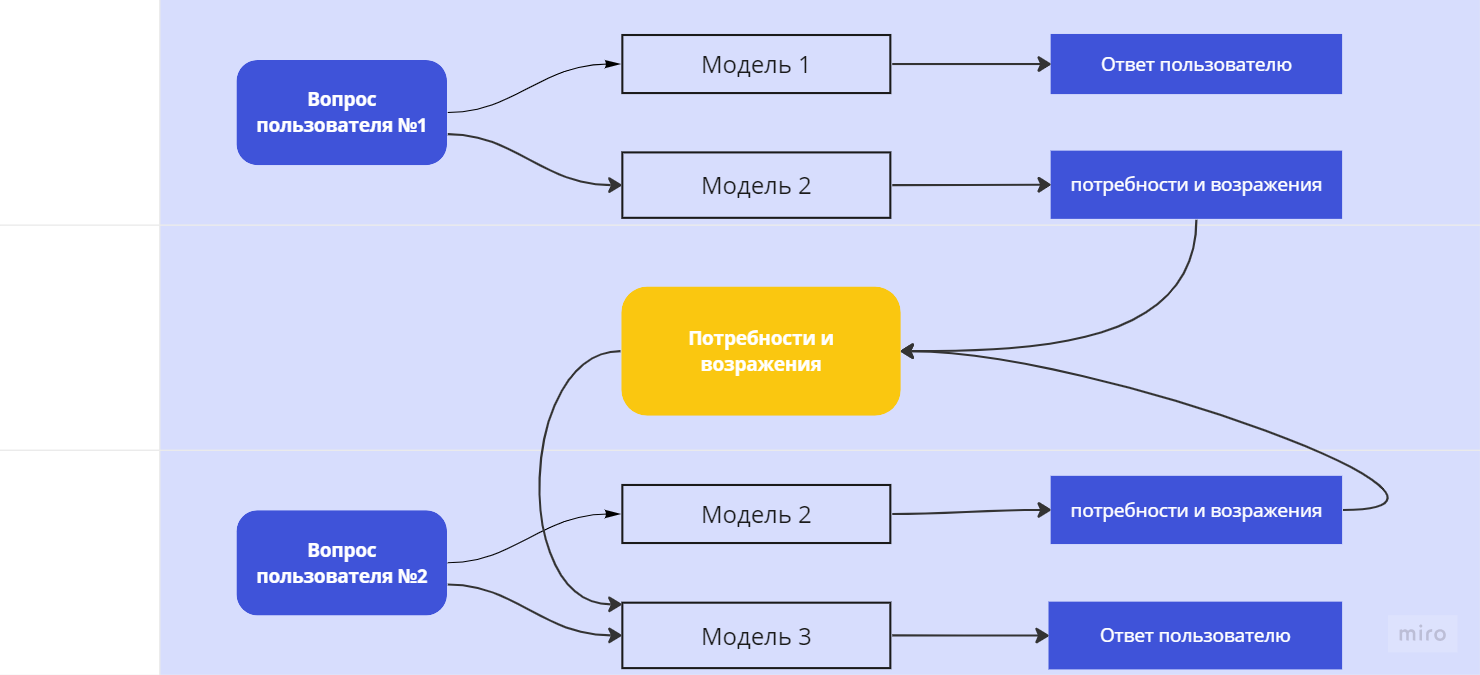

In [42]:
def run_dialog():
    clients_needs = ""
    topic = input('Клиент: ')
    answer_1 = first_model(system_1, db, topic, temperature=0)
    answer_2 = second_model(topic)
    clients_needs += answer_2
    print('\nМенеджер: ', answer_1)
    print("------------------")
    print("ответ 2 модели:", answer_2)

    while True:
        topic = input('Клиент: ')
        if topic.lower() == 'stop':
            break
        answer_3 = third_model(system_3, db, topic, clients_needs)
        answer_2 = second_model(topic)
        clients_needs += answer_2
        print('\nМенеджер: ', answer_3)
        print("------------------")
        print("ответ 2 модели:", answer_2)
        print("------------------")
        print("Выявленные потребности и возражения", clients_needs)
        print("------------------")

    return


Попробуем работу продажника на модели gpt-4o-mini

In [43]:
run_dialog()

Клиент: ghbdtn

Менеджер:  Здравствуйте! Спасибо за ваш вопрос. Похоже, что вы написали что-то не
совсем понятное. Если у вас есть конкретный вопрос о наших курсах по
искусственному интеллекту или вебинаре, пожалуйста, уточните, и я с
радостью на него отвечу.  Также мне интересно узнать, какие у вас цели
в обучении? Вы хотите трудоустроиться в сфере AI, создать собственный
проект или, возможно, просто изучаете AI как хобби?
------------------
ответ 2 модели: Потребности:  Возражения: 
Клиент: stop


In [44]:
run_dialog()

Клиент: привет

Менеджер:  Привет! Как я могу помочь вам сегодня? Есть ли у вас какие-то вопросы
о наших курсах по искусственному интеллекту или о том, как они могут
помочь вам в вашей карьере?
------------------
ответ 2 модели: Потребности:  Возражения: 
Клиент: stop


Попробуем работу продажника на модели gpt4o

In [45]:
def third_model(system_3, db, topic, user_needs):
    docs = db.similarity_search(topic, k=4)
    message_content = ' '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)])
    input_text = f"""Ты - менеджер по продажам в университете искусственного интеллекта. Ответь на вопрос пользователя на основании представленных
    документов, но на сами документы не ссылайся, клиент ничего не должен о них знать. Документ с информацией для ответа клиенту: {message_content}\n\n
    если в отчете о выявленных потребностях имеется информация о потребностях клиента, то предложи клиенту подходящий тариф.
    Если такой информации нет - задавай вопросы для выявления потребностей.
    Отчет о выявленных потребностях клиента: {user_needs} \n\nТекущий вопрос: {topic}"""
    answer_text = create_completion(MODEL_GPT_4O, system_3, input_text, 0)
    return fill(answer_text)

In [46]:
run_dialog()

Клиент: hi

Менеджер:  Здравствуйте! Как я могу помочь вам сегодня? Есть ли у вас какие-то
вопросы о наших курсах по искусственному интеллекту?
------------------
ответ 2 модели: Потребности:  Возражения: 
Клиент: stop
